In [ ]:
# Restore the kernel
import dill
dill.load_session('kernels/p4_model_kernel.db')

## Chargement des données nettoyées

In [1]:
# Load libraries
import numpy as np
import pandas as pd

In [2]:
%%capture --no-stdout --no-display

# Load binary file with cleaned data
data = pd.read_feather("p4_data.ft")

# **1. Modélisation**
Nous cherchons à élaborer un modèle de prédiction des émissions de CO2 et de la consommation totale d'énergie à partir d'un jeu de données.

Il s'agit donc d'un problème « *machine learning* » de régression (donc un problème d'apprentissage supervisé).

### Définition de la **"graine"** pour le générateur pseudo-aléatoire
Sélectionner cette graine nous permet d'opérer, lors des validations croisées, sur les mêmes plis ("*folds*") pour chaque modèle.

In [3]:
# Set random integer (seed) - 891
from random import randrange
seed = randrange(1000)
print("Seed value: ", seed)

Seed value:  90


### Séparation des variables explicatives (*features*) et des étiquettes (*targets*)
Il y a deux variables à estimer :
* 'TotalGHGEmissions': *The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent.*
* 'SiteEnergyUse(kBtu)': *The annual amount of energy consumed by the property from all sources of energy.*

In [4]:
# Features : all columns, except targets
X = data.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'])

# Choice of target (re-run the full notebook in another kernel)
# target_feature = 'SiteEnergyUse(kBtu)'
target_feature = 'TotalGHGEmissions'

# Creating target vector
y = data[target_feature]

In [5]:
X.head()

,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,DefaultData,ComplianceStatus,BuildingAge,SteamUse,NaturalGas,OtherFuelUse,FloorsGFA
0,Low-Rise Multifamily,DOWNTOWN,1.0,4.0,0.0,38172.0,75.0,False,Compliant,119,True,True,False,193532.0
1,Low-Rise Multifamily,DELRIDGE,1.0,4.0,0.0,52134.0,85.0,True,Compliant,12,False,False,False,208536.0
2,Retail Store,DOWNTOWN,1.0,4.0,0.0,NaN,91.0,False,Compliant,30,False,False,False,444308.0
3,Small- and Mid-Sized Office,DOWNTOWN,1.0,6.0,25920.0,98370.0,45.0,False,Compliant,113,False,True,False,434700.0
4,Large Office,LAKE UNION,1.0,4.0,37854.0,138672.0,59.0,False,Compliant,72,False,False,False,623736.0


In [6]:
y.head()

0    4.727919
1    2.246015
2    4.248638
3    3.876189
4    4.769328
Name: TotalGHGEmissions, dtype: float64

### Séparation des **jeux de données d'entraînement et de test**
**Remarque :** comme les hyperparamètres et le modèle seront séléctionnées par **validation croisée imbriquée**, il n'est pas nécessaire de séparer jeux d'entraînement, de test et de validation.

In [7]:
def split_data(features, target):

    from sklearn.model_selection import train_test_split

    # Splitting the data in train set and test set
    X_1, X_2, y_1, y_2 = train_test_split(
        features,
        target,
        train_size=0.8,
        test_size=0.2,
        random_state=seed
    )
    
    # Returning results
    return (X_1, X_2, y_1, y_2)

(X_train, X_test, y_train, y_test) = split_data(X, y);

### Choix de la **métrique** et Régresseur naïf (modèle de référence)
Comme métrique d'évaluation, nous utilisons le **coefficient de détermination R²** pour lequel le meilleur score est 1. Ce coefficient mesure la proportion de la variance de la variable dépendante expliquée par les variables indépendantes.

$$R^{2} = 1 - \frac{\sum\limits_{i=1}^n (y_i - \hat{y_i})^2}{\sum\limits_{i=1}^n (y_i - \bar{y})^2}$$

**Remarque :** en raison de ce choix, nous n'avons pas besoin d'entraîner un **modèle naïf** de référence. En effet, un régresseur naïf prédisant la valeur moyenne des étiquette, obtiendra un **score R² de 0**.

In [8]:
# Setting evaluation metric for regression
scoring='r2'

## Définition du **Pipeline** incluant le pré-traitement
Nous procédons à une validation croisée pour sélectionner les hyperparamètres et le modèle.

Pour que le prétraitement soit réalisé sans fuite de données, nous utiliserons un « pipeline ».

### Définition du **prétraitement différencié** selon les colonnes

Nous appliquerons un pré-traitement différencié selon que les caractéristiques sont quantitatives ou catégorielles. Dans cette partie, nous définissons ce pré-traitement dans un pipe-line pour usage ultérieur, intégré à la validation croisée.
 * imputation
 * *target encoding*
 * standardisation

In [9]:
def define_preprocessor(X):

    # Load libraries
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from category_encoders.target_encoder import TargetEncoder
    from sklearn.preprocessing import LabelEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    
    # Preprocessing pipeline for categorical features
    categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # simple imputation 
            ('target_encoder', TargetEncoder()), # target encoding
            ('scaler', StandardScaler()), # standardization after target encoding
            ])
    
    # Preprocessing pipeline for numeric features
    numeric_transformer = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=10, random_state=seed, add_indicator=True)), # iterative imputation
            ('scaler', StandardScaler()), # standardization
             ])

    # Preprocessing column-wise using pipelines for numeric and categorical features
    preprocessor = ColumnTransformer(transformers=[
            ('cat', categorical_transformer, list(X.select_dtypes(include=['category', 'bool']).columns)),
            ('num', numeric_transformer, list(X.select_dtypes(include='number').columns)),
            ])
    
    return preprocessor

preprocessor = define_preprocessor(X)

### Définition du pipe-line
Pour éviter les "fuites de données", nous effectuerons les transformations de prétraitement dans un "pipe-line" intégré à la recherche sur grille avec validation croisée.
Nous définissons un pipe-line incluant tout le pré-traitement avec un modèle de regression naïf.

**Remarque :** les véritables modèles seront définis dans les espaces de recherche.

In [10]:
from sklearn.dummy import DummyRegressor
from tempfile import mkdtemp

# Create temp directory for caching transformers: avoid repeated computation
cachedir = mkdtemp()

def define_pipeline(preprocessor, regressor):

    # Load libraries
    from sklearn.pipeline import Pipeline

    # Create a pipeline
    pipe = Pipeline([("preprocess", preprocessor), # preprocessing steps
                     ("regressor", regressor), # dummy regression model
                    ],
                    memory=cachedir,
    )
    
    # Return pipeline
    return pipe

pipe = define_pipeline(preprocessor, DummyRegressor())

In [11]:
# Testing pipeline and making the naïve baseline model
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print("Score of the naïve model: R² = {:.3f}".format(score))

Score of the baseline model: R² = -0.002


## Définition des **espaces de recherche**
Scikit-learn propose des **méthodes spécifiques** à certains algorithmes pour la sélection des hyper-paramètres. (Voir aussi :  __[documentation scikit-learn](https://scikit-learn.org/stable/modules/grid_search.html#model-specific-cross-validation)__) Néanmoins, nous choisissons d'utiliser la même méthode de recherche pour chaque algorithme.

Nous allons utiliser une recherche aléatoire sur grille avec validation croisée (*RandomizedSearchCV*). Pour des raisons de performances et de lisibilité du code, nous choississons d'établir une grille de recherche distincte pour chacun des modèles.

### ElasticNet

L'implémentation du modèle de régression linéaire régularisée *ElasticNet* dans *scikit-learn* correspond à la fonction de perte suivante :

$$ \hat{\beta} =  \underset{\beta \in \mathbb{R}^{p+1}}{\text{argmin}} [\frac{1}{2N} · ||y - X_\beta||^2_2 + \alpha  · ( \rho · ||\beta||_1 + (1 - \rho) · \frac{1}{2} · ||\beta||^2_2 )]$$

In [12]:
# Grid of research for ElasticNet
from sklearn.linear_model import ElasticNet
from scipy.stats import uniform  # uniform distr between 0 and 1

# Create space of candidate values for hyperparameters
param_grid_elastic = [{
    "regressor": [ElasticNet(max_iter=1000)], # elastic net regressor
    "regressor__alpha": np.logspace(-3, 1, 5), # penalty intensity (5 values between 10⁻³ and 10¹)
    "regressor__l1_ratio": uniform() # mixing parameter for l1 and l2 penalties
}]

### k-SVR
Machine à vecteur de support à noyau pour la régression (k-SVR)


In [13]:
# Grid of research for k-SVR
from sklearn.svm import SVR
from scipy.stats import expon
from scipy.stats import randint as sp_randint

# Create space of candidate values for hyperparameters
param_grid_svr_poly = [{# hyper-parameters for polynomial kernel
    "regressor": [SVR()], # k-SVM regressor
    "regressor__kernel": ['poly'],
    "regressor__C": expon(scale=100, loc=5), # C : penalty parameter of the error term  
    "regressor__coef0" : [0, 1], # coef0 : independent term in kernel
    "regressor__degree" : sp_randint(1, 3), # degree of the polynomial kernel function
    }]

param_grid_svr_linear = [{# hyper-parameters for linear kernel
    "regressor": [SVR()], # k-SVM regressor
    "regressor__kernel": ['linear'],
    "regressor__C": expon(scale=100, loc=5), # C : penalty parameter of the error term. y = (x - loc) / scale  
    }]

param_grid_svr_gaussian = [{# hyper-parameters for gaussian kernel
    "regressor": [SVR()], # k-SVM regressor
    "regressor__kernel": ['rbf'],
    "regressor__C": expon(scale=100, loc=5), # C : penalty parameter of the error term    
    "regressor__gamma" : [0.0001, 0.001, 0.01, 0.1], # specific for gaussian kernel
    }]

### kNN
k-plus proches voisins pour la régression (k-NN regressor) car le jeu de données est de taille réduite

In [14]:
# Grid of research for kNN
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import randint as sp_randint

# Create space of candidate values for hyperparameters
param_grid_knn = [{
    "regressor": [KNeighborsRegressor(n_jobs=-1)], # kNN regressor
    "regressor__n_neighbors": sp_randint(1, 20), # number of neighbors to consider
    "regressor__weights": ['uniform', 'distance'], # ponderation of weights of neighbors
}]

### Random Forest
Forêt aléatoire pour la régression (*random forest regressor*).

In [15]:
# Grid of research for Random Forest
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint

# Create space of candidate values for hyperparameters
param_grid_forest = [{
    "regressor": [RandomForestRegressor(n_jobs=-1, random_state=seed, n_estimators=1000)], # random forest regressor
    "regressor__max_features": sp_randint(2, 5), # number of features to consider at each node
    "regressor__max_depth": sp_randint(2, 5), # maximum depth (to prune) a stump 
    "regressor__min_samples_leaf": sp_randint(1, 100), # minimum number of samples required to be at a leaf node
}]

### AdaBoost

In [16]:
# Grid of research for AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint as sp_randint

# Create space of candidate values for hyperparameters
param_grid_adaboost = [{
    "regressor": [AdaBoostRegressor(random_state=seed)], # AdaBoost regressor
    "regressor__base_estimator": [DecisionTreeRegressor()], # Required to tune the max_depth factor
    "regressor__base_estimator__max_depth": sp_randint(2, 5), #  [2,4]
    "regressor__n_estimators": sp_randint(50, 1000), # number of weak models to iteratively train
    "regressor__learning_rate": np.logspace(-2, 1, 4), # learning rate, from 10⁻² to 10¹
    "regressor__loss": ['linear', 'square', 'exponential'], # loss function for weights update
}]

### Dictionnaire des espaces de recherche

Nous pouvons enregister les différents espaces de recherche dans un dictionnaire.

In [17]:
# Dictionnary of search spaces for each family of models
param_grids = {
    'ElasticNet': param_grid_elastic, # space of search for ElasticNet
    'kSVM poly': param_grid_svr_poly, # space of search for k-SVR with polynomial kernel
    'kSVM linear': param_grid_svr_linear, # space of search for k-SVR
    'kSVM gaussian': param_grid_svr_gaussian, # space of search for k-SVR
    'kNN': param_grid_knn, # space of search for kNN regressor
    'RandomForest': param_grid_forest, # space of search for random forest
    'AdaBoost': param_grid_adaboost, # space of search for AdaBoost regressor
              }

## **Recherche aléatoire** sur grille avec validation croisée
Nous allons optimiser le choix des hyper-paramètres en utilisant une validation croisée (interne)

**Remarque :** nous conservons la métrique par défaut de scikit-learn pour les régression : le **score R²**.

### Définition du générateur de validation croisée (interne)

In [18]:
from sklearn.model_selection import KFold

# Define the cross-validation generator
cv_inner = KFold(
    n_splits=10, # number of folds (default=5)
    shuffle=True, # shuffle the data before splitting into batche
    random_state=seed, # seeding the random number generator for shuffling
)

### Instanciations des objets RandomizedSearchCV

In [19]:
def random_searchCV(features, target, pipe):

    # Load libraries
    from sklearn.model_selection import RandomizedSearchCV

    # Initialising the dict of results of RandomizedSearchCV
    CVsearch_dict = {}

    # Iterating over models and related parameters grids
    for model, param_grid in param_grids.items():
        print("\nProceeding RandomizedSearchCV for {}…".format(model))
        # Handle case where there are different dicts in param_grid (k-SVR…)
        for param_grid_dict in param_grid:

            # Intenciation of RandomizedSearchCV object
            randomsearch = RandomizedSearchCV(
                pipe, # use of the pipeline (preprocessing + model dummy)
                param_distributions=param_grid_dict, # choice of hyper-parameters to test
                scoring=scoring, # scoring method for regression
                cv=cv_inner, # cross-validation generator
                n_jobs=-1, # use all available cores (parallelization)
                iid=False, # to avoid a DeprecationWarning
                return_train_score=True, # to avoid a DeprecationWarning
                n_iter=10, # number of combinations of hyper-parameters to try
            )

            # Searching for best hyper-parameters, and saving in dict
            CVsearch_dict[model] = randomsearch.fit(features, target)

            # Getting standard deviation for best_model scores
            best_index = randomsearch.best_index_
            std_score = randomsearch.cv_results_['std_test_score'][best_index]

            # Displays the parameters of the best model
            print("Best parameters found for {}:".format(model))

            # Getting parameters from param_grid
            for parameter, _ in param_grid_dict.items():
                if parameter != 'regressor':
                    best_parameter = randomsearch.best_estimator_.get_params()[parameter]
                    parameter = parameter.split("regressor__")[1]   
                    # Display best parameter
                    print("  - " + parameter + ":", best_parameter)

            # Getting the best score
            print("\nMean cross-validated score of the best estimator for {}: R² = {:.3f} ± {:.3f}".format(model, randomsearch.best_score_, std_score))
    
    # Returns dictionnary with results
    return CVsearch_dict

### **Exécution** de la recherche

In [20]:
CVsearch_dict = random_searchCV(X_train, y_train, pipe)


Proceeding RandomizedSearchCV for ElasticNet…
Best parameters found for ElasticNet:
  - alpha: 0.001
  - l1_ratio: 0.259636400733552

Mean cross-validated score of the best estimator for ElasticNet: R² = 0.668 ± 0.031

Proceeding RandomizedSearchCV for kSVM poly…
Best parameters found for kSVM poly:
  - kernel: poly
  - C: 23.26966255748342
  - coef0: 1
  - degree: 1

Mean cross-validated score of the best estimator for kSVM poly: R² = 0.653 ± 0.048

Proceeding RandomizedSearchCV for kSVM linear…
Best parameters found for kSVM linear:
  - kernel: linear
  - C: 217.30579810246377

Mean cross-validated score of the best estimator for kSVM linear: R² = 0.653 ± 0.048

Proceeding RandomizedSearchCV for kSVM gaussian…
Best parameters found for kSVM gaussian:
  - kernel: rbf
  - C: 5.7937216568218926
  - gamma: 0.01

Mean cross-validated score of the best estimator for kSVM gaussian: R² = 0.744 ± 0.030

Proceeding RandomizedSearchCV for kNN…
Best parameters found for kNN:
  - n_neighbors: 10

### **Récupération** du meilleur modèle (pipeline : pré-traitement + régresseur)

In [21]:
def get_best_model(CVsearch_dict):
    """Return the best_model from CVsearch_dict."""

    # Initializing best score
    best_score = 0

    # Iterating over models
    for model, model_CVsearch in CVsearch_dict.items():

        # Selecting model with best score
        if model_CVsearch.best_score_ > best_score:
            # Updating best_score and best_model
            best_model_name = model
            best_score = model_CVsearch.best_score_
            best_model = model_CVsearch.best_estimator_

    # Display results
    print("\nThe overall best cross-validated score is : R² = {:.3f}".format(best_score))
    print("The best model is {} with parameters: ".format(best_model_name))

    # Getting parameters from param_grid
    for parameter, _ in param_grids[best_model_name][0].items():
        if parameter != 'regressor':
            best_parameter = best_model.get_params()[parameter]

            # Display best parameter
            parameter = parameter.split("regressor__")[1]
            print("  - " + parameter + ":", best_parameter)

    return best_model

model_GHG = get_best_model(CVsearch_dict)


The overall best cross-validated score is : R² = 0.744
The best model is kSVM gaussian with parameters: 
  - kernel: rbf
  - C: 5.7937216568218926
  - gamma: 0.01


# **2. Interprétations** des résultats

### **Évaluation finale** du meilleur modèle sur le jeu de test

In [22]:
score_train = model_GHG.score(X_train, y_train)
print("Score of the best model on the train set: R² = {:.3f}".format(score_train))

score_test_GHG = model_GHG.score(X_test, y_test)
print("Score of the best model on the test set: R² = {:.3f}".format(score_test_GHG))

Score of the best model on the train set: R² = 0.777
Score of the best model on the test set: R² = 0.731


### **Comparaison** et visualisation de la **précision** des modèles (fonction de perte)
Nous comparons les performances sur les jeu d'entraînement, de validation et de le jeu de test pour chaque modèle.

In [24]:
# Initializing a Pandas.DataFrame for results
results_df = pd.DataFrame(columns = ['mean_score_CV', 'std_score_CV', 'test_score'])

# Getting result for best_estimator of each model
for model, model_CVsearch in CVsearch_dict.items():
    
    # Creating a new row in the pd.DataFrame
    results_df.loc[model] = [0, 0, 0]
    
    # Adding cross-validated score of best_estimator in the pd.DataFrame
    mean_score_CV = model_CVsearch.best_score_
    results_df.loc[model]['mean_score_CV'] = mean_score_CV
    
    # Adding cross-validated score standard deviation for best_estimators
    std_score_CV = CVsearch_dict[model].cv_results_['std_test_score'][CVsearch_dict[model].best_index_]
    results_df.loc[model]['std_score_CV'] = std_score_CV
    
    # Adding test score of best_estimator in the pd.DataFrame
    score_test = model_CVsearch.best_estimator_.score(X_test, y_test)
    results_df.loc[model]['test_score'] = score_test
    
results_df = results_df.sort_values(by='test_score', ascending=False)
results_df

,mean_score_CV,std_score_CV,test_score
kSVM gaussian,0.743616,0.0299048,0.730872
AdaBoost,0.718436,0.0359817,0.71046
kNN,0.684827,0.0381856,0.664624
ElasticNet,0.66833,0.0313768,0.649907
RandomForest,0.640315,0.0258163,0.636264
kSVM poly,0.652695,0.0484537,0.618876
kSVM linear,0.652786,0.0483331,0.618473


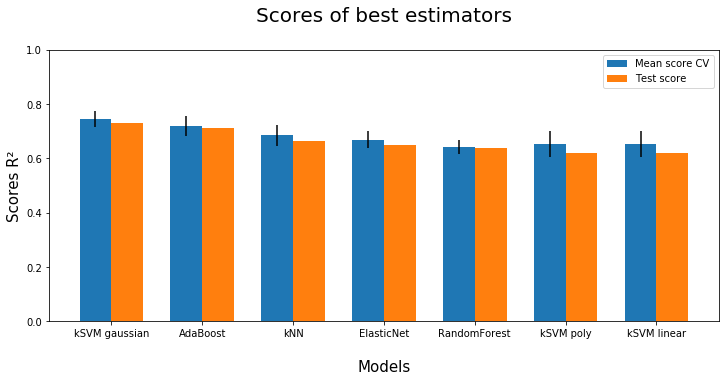

In [25]:
import matplotlib.pyplot as plt

# Plotting with a bar plot
x = np.arange(len(results_df))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x - width/2, results_df['mean_score_CV'], width, yerr=results_df['std_score_CV'], label='Mean score CV')
rects2 = ax.bar(x + width/2, results_df['test_score'], width, label='Test score')

plt.title('Scores of best estimators\n', fontsize = 20)
plt.xlabel('\nModels', fontsize = 15)
plt.ylabel('Scores R²', fontsize = 15)

ax.set_ylim(top=1)

plt.xticks(x, results_df.index)
ax.legend();

fig.savefig('plots/scoresR2.png');

### Comparaison des différentes **métriques** de performance pour les modèles

$$R^{2} = 1 - \frac{\sum\limits_{i=1}^n (y_i - \hat{y_i})^2}{\sum\limits_{i=1}^n (y_i - \bar{y})^2}    ;    MSE = \frac{1}{n} \sum\limits_{i=1}^n (y_i - \hat{y_i})^{2}    ;   MAE = \frac{1}{n} \sum\limits_{i=1}^n |y_i - \hat{y_i}| $$

In [26]:
# Import the metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Dict of metrics
metrics_dict = {'R² scores':r2_score,
          'MAE scores':mean_absolute_error,
          'MSE scores':mean_squared_error,}

# Initializing a Pandas.DataFrame for results
results_df = pd.DataFrame(columns=list(metrics_dict.keys()))

# Iterating over models
for model_name, model_CVsearch in CVsearch_dict.items():
    
    # Creating a new row for the model
    results_df.loc[model_name] = np.zeros(len(metrics_dict))
    
    # Getting the best_estimator from the GridSearch
    model = model_CVsearch.best_estimator_
    
    # Calculating predicted values on test set
    y_pred = model.predict(X_test)
    
    # for each metric…
    for metric_name, metric in metrics_dict.items():
        # Calculating metric value on test set
        score = metric(y_test, y_pred)
        # Adding the score to the result summary
        results_df.loc[model_name][metric_name] = score
        
# Sort and Display results
results_df = results_df.sort_values(by='R² scores', ascending=False)
results_df

,R² scores,MAE scores,MSE scores
kSVM gaussian,0.730872,0.506270,0.488664
AdaBoost,0.710460,0.546200,0.525726
kNN,0.664624,0.569964,0.608950
ElasticNet,0.649907,0.603115,0.635674
RandomForest,0.636264,0.657260,0.660444
kSVM poly,0.618876,0.599182,0.692017
kSVM linear,0.618473,0.599201,0.692748


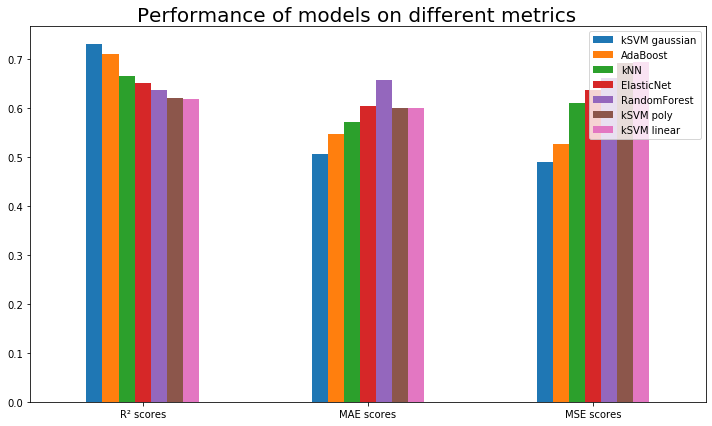

In [27]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Performance of models on different metrics', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df.T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.96])

fig.savefig('plots/metrics.png');

Nous avons: $R^{2} = 1 - \frac{\sqrt{MSE}}{\sigma^2}$

### **Prédictions vs valeurs réelles** (sur le jeu de test)

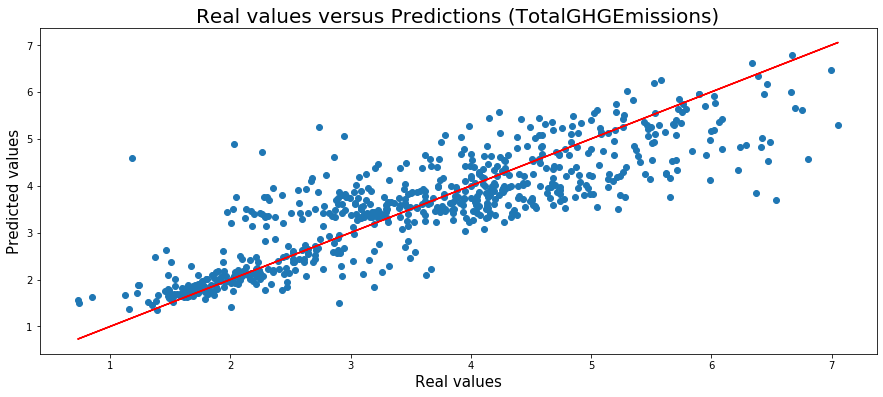

In [28]:
import matplotlib.pyplot as plt

# Defining the real values for target feature
y_real = y_test

# Calculating predictions on testing set
y_predicted = model_GHG.predict(X_test)

# Setting parameters of the plot
fig = plt.figure(figsize=(15, 6))
plt.title('Real values versus Predictions ({})'.format(target_feature), fontsize=20)
plt.xlabel('Real values', fontsize=15)
plt.ylabel('Predicted values', fontsize=15)

# Plotting the scatter plot
plt.scatter(y_real, y_predicted)

# Plotting the x=y line
plot = plt.plot(y_real, y_real, color='red')

fig.savefig('plots/PredictedVsReal.png');

## **Importance des caractéristiques** (*features importance*)
Certains modèles permettent d'inspecter l'importance relative des variables explicatives :
* la régression linéaire (ElasticNet)
* la forêt aléatoire (RandomForest)
* la méthode de boosting (AdaBoost)

In [29]:
# Getting name of features from initial data
features_names = list(X)

# Creating a Pandas DataFrame
features_importance = pd.DataFrame(index=features_names)

# Features importance for each model (dropping indicators of imputation)
#-----------------------------------
# ElasticNet
features_importances = CVsearch_dict['ElasticNet'].best_estimator_.get_params()['regressor'].coef_
features_importance['ElasticNet'] = features_importances[:len(features_names)]
# RandomForest
features_importances = CVsearch_dict['RandomForest'].best_estimator_.get_params()['regressor'].feature_importances_
features_importance['RandomForest'] = features_importances[:len(features_names)]
# AdaBoost
features_importances = CVsearch_dict['AdaBoost'].best_estimator_.get_params()['regressor'].feature_importances_
features_importance['AdaBoost'] = features_importances[:len(features_names)]

# Computing relative importance
for column in list(features_importance):
    features_importance[column] = features_importance[column].map(abs)
    features_importance[column] /= features_importance[column].sum()

# Computing "mean importance", and sorting
features_importance["Mean"] = features_importance.mean(axis=1)
features_importance = features_importance.sort_values(by="Mean", ascending=False)

features_importance.head()

,ElasticNet,RandomForest,AdaBoost,Mean
LargestPropertyUseTypeGFA,0.287952,0.366253,0.523582,0.392596
SteamUse,0.219972,0.226947,0.280591,0.242503
FloorsGFA,0.092299,0.145151,0.090950,0.109467
PropertyGFAParking,0.089741,0.032965,0.044006,0.055570
ComplianceStatus,0.064158,0.072702,0.000744,0.045868


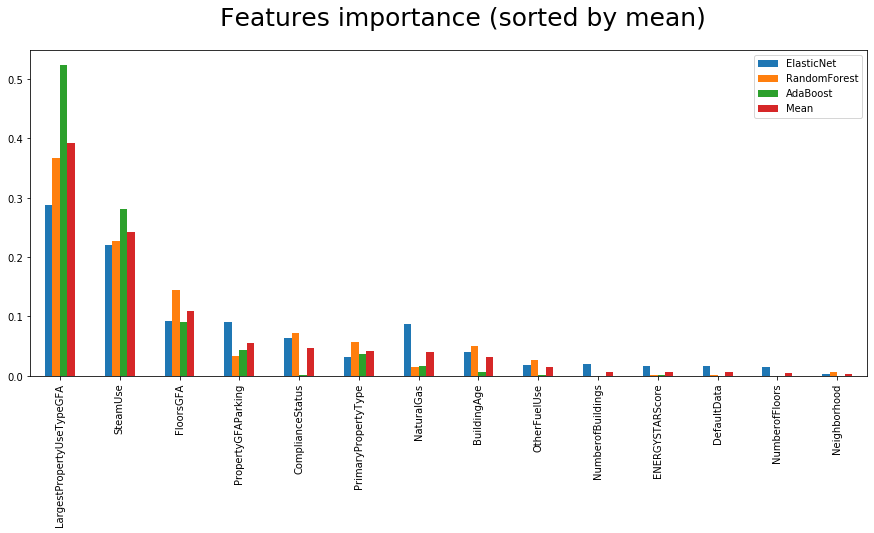

In [30]:
fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(15)
fig.suptitle('       Features importance (sorted by mean)', fontsize=25)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(
    # number of rows and columns
    nrows=1,
    ncols=1,
    # adjust relative dimensions
    #height_ratios=[3, 1], # heights of rows
    #width_ratios=[1], # width of columns
    )

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
features_importance.plot.bar(ax=ax1);
fig.savefig('plots/FeaturesImportance.png');

## Intérêt de la variable **'ENERGY STAR Score'**

Nous cherchons en particulier à évaluer l'intérêt de l’'ENERGY STAR Score' ([www.energystar.gov](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what)) pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par l'équipe.
* 'ENERGYSTARScore' : An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.

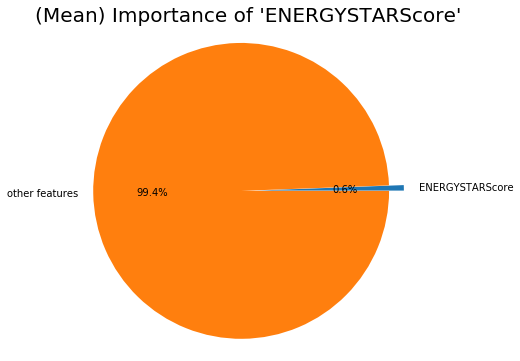

In [31]:
# Setting labels of the pie-plot
labels = ['ENERGYSTARScore', 'other features']

# Getting the relative importance of 'ENERGYSTARScore'
sizes = [features_importance.loc['ENERGYSTARScore', "Mean"], 1-features_importance.loc['ENERGYSTARScore', "Mean"]]

# only "explode" the 'ENERGYSTARScore' slice
explode = (0.1, 0) 

fig, ax1 = plt.subplots(figsize=(6, 6))

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("(Mean) Importance of 'ENERGYSTARScore'", fontsize=20)
plt.show()
fig.savefig('plots/EnergyStar.png');

Nous constatons que la variable 'ENERGYSTARScore' possède une **importance négligeable** dans les modèles entraînées. Si cet indicateur est fastidieux à calculer, il pourrait être abandonné sans dommage pour les performances du modèle.

## **Effets de la taille du jeu de données** d'entraînement (*learning curve*)
Nous étudions l'impact de la taille du jeu de données d'entraînement pour déterminer si notre modèle gagnerait en exactitude à être entraîné sur un nombre plus important de données. Autrement dit : la ville de Seattle pourrait-elle déjà utiliser le modèle, ou devrait-elle continuer à collecter des données ?

Pour obtenir les résultats les plus fiables possibles, et estimer la variance de nos résultats, nous allons utiliser une **validation croisée**.

### Définition du **générateur** de validation croisée

In [32]:
from sklearn.model_selection import KFold

# Define the cross-validation generator
cv_learning = KFold(
    n_splits=3, # number of folds (default=5)
    shuffle=True, # shuffle the data before splitting into batche
    random_state=seed, # seeding the random number generator for shuffling
)

### Évaluation du modèle sur des jeux d'entraînement de **taille croissante**

In [33]:
from sklearn.model_selection import learning_curve

# Create CV training and test scores for various training test sizes
train_sizes, train_scores, test_scores = learning_curve(
    model_GHG, # estimator
    X, # features
    y, # target
    cv=cv_learning, # cross-validation generator
    scoring='r2', # performance metric
    n_jobs=-1, # use all computer cores
    train_sizes=np.linspace(0.01, 0.99, 50), # 50 training sets
)

### Calcul des **moyennes et écarts-types**

In [34]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

### **Courbe d'apprentissage**

In [35]:
# We change negative values to zero to avoid crushing the graph
train_mean = [0 if score < 0 else score for score in train_mean]
test_mean = [0 if score < 0 else score for score in test_mean]

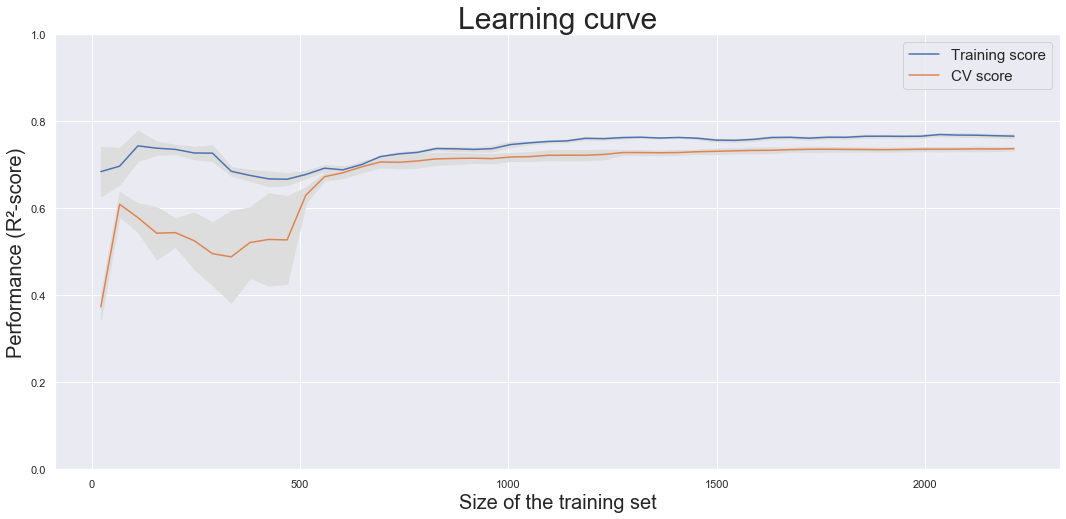

In [36]:
# Loading libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()

# Setting main properties
fig, ax = plt.subplots(figsize=(18, 8))
plt.title("Learning curve", fontsize=30)
plt.xlabel("Size of the training set", fontsize=20)
plt.ylabel("Performance (R²-score)", fontsize=20)
ax.set_ylim(top=1)

# Draw bands (for standard deviation)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Graphing the plot
ax.plot(train_sizes, train_mean, label='Training score')
ax.plot(train_sizes, test_mean, label='CV score')
plt.legend(loc='best', fontsize=15);

fig.savefig('plots/learning_curve.png');

## **Impact du nombre d'arbres** de la forêt aléatoire
Nous avons séléctionnés arbitrairement un nombre d'arbres égal à 1'000. Les forêts ont ceci de particulier, que la précision ne peut qu'augmenter avec le nombre d'arbres.
Nous allons regarder quel est l'impact du nombre d'arbres sur les performances (précision, temps d'entraînement et temps de prédiction) du modèle.

In [37]:
import math

# Getting best parameters of the RandomForest model
#--------------------------------------------------
# Initializing dictionnary of parameters for RandomForest
params_dict = {}

# Getting the name of the parameter from search space
for parameter, _ in param_grids['RandomForest'][0].items():
    if parameter != 'regressor':
        
        # Getting the value of the fitted parameter
        # best_parameter = best_model.get_params()[parameter]
        best_parameter = CVsearch_dict['RandomForest'].best_estimator_.get_params()[parameter]
        
        # Getting the truncated name of the parameter
        parameter = parameter.split("regressor__")[1]
        
        # Add parameter to dictionnary
        params_dict[parameter] = best_parameter

# Training, timing and scoring models
#------------------------------------
# Initializations
n_estimators_list = []
times_train = []
scores_oob = []
times_predict = []
NB_POINTS = 15
MAX_ESTIMATORS = 10000

# Iterating on the number of the trees (from 10¹ to 10⁵)
# for n_estimators in np.logspace(2, 4, 15):
    # n_estimators has to be an integer
    # n_estimators = math.floor(n_estimators)
    # n_estimators_list.append(n_estimators)

# Iterating on points
for i in range(1, NB_POINTS+1):
    n_estimators = math.floor(MAX_ESTIMATORS/i)
    n_estimators_list.append(n_estimators)
    
    # Instanciating the model
    forestregressor = RandomForestRegressor(
        n_estimators=n_estimators,
        n_jobs=-1,
        oob_score=True,
        random_state=seed,
        **params_dict)
    
    # Define pipeline with preprocessing and dummy model
    forestmodel = define_pipeline(preprocessor, forestregressor)
    
    # Training the model and evaluating training time (on whole data set)
    time_train = %timeit -n1 -r1 -o -q forestmodel.fit(X, y)
    times_train.append(time_train.average)

    # Évaluating the accuracy of the forest on out-of-bag error
    score_oob_list = []
    for k in range(i): # iterating for stability
        forestmodel = define_pipeline(preprocessor, forestregressor)
        forestmodel.fit(X, y)
        score_oob = forestregressor.oob_score_
        score_oob_list.append(score_oob)
    # Computing the mean and adding to list of results
    score_oob_mean = sum(score_oob_list)/len(score_oob_list)
    scores_oob.append(score_oob_mean)
    
    # Évaluating predict time on a sample of size 1'000
    X_sample = X_train[:1000]
    time_predict = %timeit -n1 -r3 -o -q forestmodel.predict(X_sample)
    times_predict.append(time_predict.average)

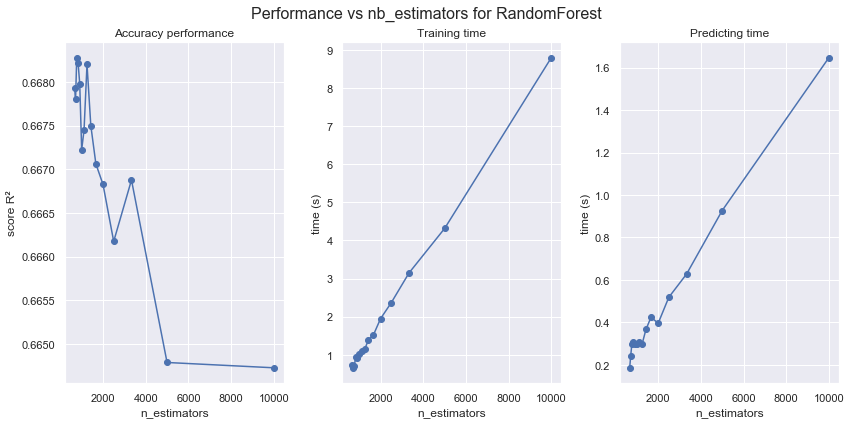

In [38]:
# Set the axis for the score
def scores_forest_axes(ax=None):
    
    x = n_estimators_list
    y = scores_oob
    
    # Content of the axes
    ax.plot(x, y, 'o-')
    
    # Properties of the axes
    ax.set_title('Accuracy performance')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('score R²')

# Set the axis for the training time
#-----------------------------------
def training_time_forest_axes(ax=None):
    
    x = n_estimators_list
    y = times_train
    
    # Content of the axes
    ax.plot(x, y, 'o-')
    
    # Properties of the axes
    ax.set_title('Training time')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('time (s)')

# Set the axis for the predicting time
#----------------------------------
def predicting_time_forest_axes(ax=None):
    
    x = n_estimators_list
    y = times_predict
    
    # Content of the axes
    ax.plot(x, y, 'o-')
    
    # Properties of the axes
    ax.set_title('Predicting time')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('time (s)')

# Set the whole figure
#---------------------
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(12)
fig.suptitle('Performance vs nb_estimators for RandomForest', fontsize=16)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=3,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# Call to the functions that fill the axes
scores_forest_axes(ax1)
training_time_forest_axes(ax2)
predicting_time_forest_axes(ax3)

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.96])

fig.savefig('plots/RF_nbtrees.png');

Nous constatons une augmentation asymptotique du score R² mais une croissance linéaire du temps d'entraînement et du temps de prédiction.

# **3. Expérimentations** diverses

In [39]:
def build_model(features, target):
    """
    This function proceed to all the steps for building a model:
    - Fitting and applying preprocessor
    - Proceeding to the RandomizedSearchCV
    - Getting and returning "best model" from C.V.
    """
    
    # Built preprocessing step adapted to the shape of X
    preprocessor = define_preprocessor(features)

    # Define pipeline with preprocessing and dummy model
    from sklearn.dummy import DummyRegressor
    pipe = define_pipeline(preprocessor, DummyRegressor())
    
    # Fitting pipeline
    #pipe.fit(features, target) - already in random_searchCV

    # Proceed the RandomizedSearchCV
    CVsearch_dict = random_searchCV(features, target, pipe)

    # Getting best_model from the RandomizedSearchCV
    best_model = get_best_model(CVsearch_dict)

    # Returns the best model
    return best_model

##  **Tentative d'hybridation** (*model stacking*)

### Séparation d'un jeu de validation (ou de développement) à partir du jeu de test

In [40]:
# Creating target vector
target_feature = 'TotalGHGEmissions'
y = data[target_feature]

# Getting features matrix
X = data.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])

# Splitting in training, validation and testing sets
(X_train, X_test, y_train, y_test) = split_data(X, y);

# Splitting the test set in validation set and test set
SIZE = int(len(X_test)/2)

X_valid = X_test[:SIZE]
y_valid = y_test[:SIZE]

X_test = X_test[SIZE:]
y_test = y_test[SIZE:]

### Récupération des prédictions de chaque modèle pour les jeux d'entraînement et de test

In [41]:
# Initialising the list of models to hybrid
bestmodels_list = []

# Iteration over models with fitted hyper-parameters
for model, _ in param_grids.items():
    # Adding best model for each algorithm to the list
    bestmodels_list.append(CVsearch_dict[model].best_estimator_)

# Initialising the dataframe with predictions from models to stack
X_valid_stacked = X_valid.copy()
X_test_stacked = X_test.copy()

# Getting predictions from each model
for index, model in enumerate(bestmodels_list):
    X_valid_stacked["model_"+str(index)] = model.predict(X_valid)
    X_test_stacked["model_"+str(index)] = model.predict(X_test)

# Displays results
# X_valid_stacked.head()

### Instanciation d'un modèle de régression pour le stacking
Nous faisons le choix de ne pas optimiser les hyper-paramètres pour simplifier la démarche.

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Define the model for stacking
stacked_model = RandomForestRegressor(n_estimators=1000, max_features=3)

# Re-fit preprocessor
stacked_prepro = define_preprocessor(X_valid_stacked)

# Re-define the pipeline with preprocessing and LinearRegression
stacked_pipe = define_pipeline(stacked_prepro, stacked_model)

# Training the model on the X_valid set, with added features
stacked_pipe.fit(X_valid_stacked, y_valid)

# Scoring (R²) the stacked model
score_test = stacked_pipe.score(X_test_stacked, y_test)

print("\nScore of the stack model on test set is: R² = {:.3f}".format(score_test))
print("Compared to the main model, this represent an evolution of: {:.3f}".format(score_test-score_test_GHG))


Score of the stack model on test set is: R² = 0.743
Compared to the main model, this represent an evolution of: 0.012


Il semble que le jeu initial de données soit trop restreint pour que nous puissions tirer avantage du modèle stacking. En effet, la démarche nécessite :
* découper le jeu initial en jeu de d'entraînement et jeu de test (si l'on fait une validation croisée)
* à nouveau diviser le jeu de test précédent en un jeu d'entraînement et jeu de test pour le modèle hybride (en refaisant une validation croisée pour optimiser les paramètres ou fiabiliser l'évaluation des performances).

## **Réseaux de neurones** (avec *Keras*)

In [43]:
# Creating target vector
target_feature = 'TotalGHGEmissions'
y = data[target_feature]

# Getting features matrix
X = data.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])

# Splitting in training, validation and testing sets
(X_train, X_test, y_train, y_test) = split_data(X, y);
(X_train, X_val, y_train, y_val) = split_data(X_train, y_train);

In [44]:
# Defining preprocessing steps
preprocessor = define_preprocessor(X)

# Fitting and applying pre-processing
X_train = preprocessor.fit_transform(X_train, y_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [45]:
from keras import backend as K

# Defining custom metric for regression : coefficient of determination R²
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return -( 1 - SS_res/(SS_tot + K.epsilon()) ) # set negative for compatibility

Using TensorFlow backend.


In [46]:
import keras

# Defining callback for early stopping
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_coeff_determination', # R^2 score on validation set
        patience=2, # interrupt training
    ),
]

In [47]:
%%capture --no-stdout --no-display

from keras import models
from keras import layers

# Getting number of features
nb_features = X_train.shape[1]

# Defining architecture of the neural network
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(nb_features,)))
network.add(layers.Dense(1)) # no activation function for regression

network.compile(optimizer='rmsprop',
                loss='mean_squared_error',
                metrics=[coeff_determination]
)

# Fitting the neural network model
network.fit(X_train, y_train,
            epochs=45,
            batch_size=32,
            callbacks=callbacks_list,
            validation_data=(X_val, y_val), # required for early stopping
           )

Train on 2147 samples, validate on 537 samples
Epoch 1/45
2147/2147 [==============================] - 0s 204us/step - loss: 3.1575 - coeff_determination: 0.8464 - val_loss: 0.9028 - val_coeff_determination: -0.4550
Epoch 2/45
2147/2147 [==============================] - 0s 29us/step - loss: 0.7826 - coeff_determination: -0.5357 - val_loss: 0.6407 - val_coeff_determination: -0.6097
Epoch 3/45
2147/2147 [==============================] - 0s 36us/step - loss: 0.6149 - coeff_determination: -0.6406 - val_loss: 0.5635 - val_coeff_determination: -0.6561
Epoch 4/45
2147/2147 [==============================] - 0s 36us/step - loss: 0.5482 - coeff_determination: -0.6823 - val_loss: 0.5307 - val_coeff_determination: -0.6752
Epoch 5/45
2147/2147 [==============================] - 0s 36us/step - loss: 0.4972 - coeff_determination: -0.7052 - val_loss: 0.5368 - val_coeff_determination: -0.6708
Epoch 6/45
2147/2147 [==============================] - 0s 29us/step - loss: 0.4746 - coeff_determination: -

## Modèle **sans** la variable **'*ENERGYSTARScore*'**

In [48]:
# Creating target vector
target_feature = 'TotalGHGEmissions'
y = data[target_feature]

# Getting features matrix without 'ENERGYSTARScore'
X = data.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore'])

# Splitting in training, validation and testing sets
(X_train, X_test, y_train, y_test) = split_data(X, y);

# Building the model without 'ENERGYSTARScore'
model_wo_ENERGIE = build_model(X_train, y_train)

# Evaluating the model without 'ENERGYSTARScore'
score_test = model_wo_ENERGIE.score(X_test, y_test)
print("\nScore of the model without 'ENERGYSTARScore' on test set is: R² = {:.3f}".format(score_test))
print("Compared to the main model, this represent an evolution of: {:.3f}".format(score_test-score_test_GHG))


Score of the model with 'ENERGYSTARScore' on test set is: R² = 0.731

Proceeding RandomizedSearchCV for ElasticNet…
Best parameters found for ElasticNet:
  - alpha: 0.001
  - l1_ratio: 0.711756484445036

Mean cross-validated score of the best estimator for ElasticNet: R² = 0.638 ± 0.030

Proceeding RandomizedSearchCV for kSVM poly…
Best parameters found for kSVM poly:
  - kernel: poly
  - C: 8.141695333994882
  - coef0: 1
  - degree: 1

Mean cross-validated score of the best estimator for kSVM poly: R² = 0.623 ± 0.047

Proceeding RandomizedSearchCV for kSVM linear…
Best parameters found for kSVM linear:
  - kernel: linear
  - C: 224.03549054627848

Mean cross-validated score of the best estimator for kSVM linear: R² = 0.623 ± 0.047

Proceeding RandomizedSearchCV for kSVM gaussian…
Best parameters found for kSVM gaussian:
  - kernel: rbf
  - C: 125.71513358441486
  - gamma: 0.01

Mean cross-validated score of the best estimator for kSVM gaussian: R² = 0.711 ± 0.030

Proceeding Randomiz

## Modèle incluant **toutes les variables** du jeu de données initiales

In [49]:
%%capture --no-stdout --no-display

# Load binary file with cleaned data
data_RAW = pd.read_csv("p4_data_raw.csv")

# Choice of target (re-run the full notebook in another kernel)
target_feature = 'TotalGHGEmissions'

# Creating target vector
y = data_RAW[target_feature]

# Getting the features' matrix
X = data_RAW.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])

# Split data set into training set and testing set
(X_train, X_test, y_train, y_test) = split_data(X, y)

# Building the model with the 'SiteEnergyUse(kBtu)' target
model_RAW = build_model(X_train, y_train)

# Evaluating the model built with all raw features
score_test = model_RAW.score(X_test, y_test)
print("\nScore of the modelisation with ALL variables on test set is: R² = {:.3f}".format(score_test))
print("Compared to the main model, this represent an evolution of: {:.3f}".format(score_test-score_test_GHG))


Proceeding RandomizedSearchCV for ElasticNet…
Best parameters found for ElasticNet:
  - alpha: 0.01
  - l1_ratio: 0.2865553706598435

Mean cross-validated score of the best estimator for ElasticNet: R² = 0.973 ± 0.076

Proceeding RandomizedSearchCV for kSVM poly…
Best parameters found for kSVM poly:
  - kernel: poly
  - C: 201.40063620056878
  - coef0: 0
  - degree: 1

Mean cross-validated score of the best estimator for kSVM poly: R² = 0.994 ± 0.018

Proceeding RandomizedSearchCV for kSVM linear…
Best parameters found for kSVM linear:
  - kernel: linear
  - C: 170.10017833297258

Mean cross-validated score of the best estimator for kSVM linear: R² = 1.000 ± 0.000

Proceeding RandomizedSearchCV for kSVM gaussian…
Best parameters found for kSVM gaussian:
  - kernel: rbf
  - C: 380.5449113086169
  - gamma: 0.0001

Mean cross-validated score of the best estimator for kSVM gaussian: R² = 0.451 ± 0.150

Proceeding RandomizedSearchCV for kNN…
Best parameters found for kNN:
  - n_neighbors: 

## Modèle à partir des axes principaux d'inerties de l'**ACP**

In [50]:
# Load ACP components from .csv file
from numpy import genfromtxt
data_PCA = genfromtxt('p4_dataPCA.csv', delimiter=',')

# Converting to pd.DataFrame
data_PCA = pd.DataFrame(data_PCA)

# Creating features' matrix ('SiteEnergyUse(kBtu)' already removed)
X = data_PCA.iloc[:,:-1]

# Get target vector ('TotalGHGEmissions') from last column 
y = data_PCA.iloc[:,-1]

# Split data set into training set and testing set
(X_train, X_test, y_train, y_test) = split_data(X, y)

# Building the model with the 'TotalGHGEmissions' target
model_PCA = build_model(X_train, y_train)

# Evaluating the model with PCA features
score_test = model_PCA.score(X_test, y_test)
print("\nScore of the modelisation from ACP on test set is: R² = {:.3f}".format(score_test))
print("Compared to the main model, this represent an evolution of: {:.3f}".format(score_test-score_test_GHG))


Proceeding RandomizedSearchCV for ElasticNet…
Best parameters found for ElasticNet:
  - alpha: 0.001
  - l1_ratio: 0.0540256623920794

Mean cross-validated score of the best estimator for ElasticNet: R² = 0.705 ± 0.027

Proceeding RandomizedSearchCV for kSVM poly…
Best parameters found for kSVM poly:
  - kernel: poly
  - C: 376.6152495173975
  - coef0: 0
  - degree: 1

Mean cross-validated score of the best estimator for kSVM poly: R² = 0.700 ± 0.025

Proceeding RandomizedSearchCV for kSVM linear…
Best parameters found for kSVM linear:
  - kernel: linear
  - C: 38.99941158626001

Mean cross-validated score of the best estimator for kSVM linear: R² = 0.700 ± 0.024

Proceeding RandomizedSearchCV for kSVM gaussian…
Best parameters found for kSVM gaussian:
  - kernel: rbf
  - C: 84.22361801369564
  - gamma: 0.01

Mean cross-validated score of the best estimator for kSVM gaussian: R² = 0.754 ± 0.029

Proceeding RandomizedSearchCV for kNN…
Best parameters found for kNN:
  - n_neighbors: 7
 

## Modèle intégrant les **valeurs hors-normes**

In [51]:
%%capture --no-stdout --no-display

# Load binary file with outliers
data_w_outliers = pd.read_feather("p4_data_w_outliers.ft")

# Get target vector ('TotalGHGEmissions') from last column 
feature_name = 'TotalGHGEmissions'
y = data_w_outliers[feature_name]

# Creating features' matrix
X = data_w_outliers.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])

# Split data set into training set and testing set
(X_train, X_test, y_train, y_test) = split_data(X, y)

# Building the model with the 'SiteEnergyUse(kBtu)' target
model_OUTLIERS = build_model(X_train, y_train)

# Evaluating the model with PCA features
score_test = model_OUTLIERS.score(X_test, y_test)
print("\nScore of the modelisation WITH outliers on test set is: R² = {:.3f}".format(score_test))
print("Compared to the main model, this represent an evolution of: {:.3f}".format(score_test-score_test_GHG))


Proceeding RandomizedSearchCV for ElasticNet…
Best parameters found for ElasticNet:
  - alpha: 0.1
  - l1_ratio: 0.2997249252943345

Mean cross-validated score of the best estimator for ElasticNet: R² = 0.411 ± 0.594

Proceeding RandomizedSearchCV for kSVM poly…
Best parameters found for kSVM poly:
  - kernel: poly
  - C: 9.515812088903775
  - coef0: 0
  - degree: 1

Mean cross-validated score of the best estimator for kSVM poly: R² = -0.388 ± 3.128

Proceeding RandomizedSearchCV for kSVM linear…
Best parameters found for kSVM linear:
  - kernel: linear
  - C: 67.80633003671605

Mean cross-validated score of the best estimator for kSVM linear: R² = -0.396 ± 3.146

Proceeding RandomizedSearchCV for kSVM gaussian…
Best parameters found for kSVM gaussian:
  - kernel: rbf
  - C: 28.602018907905823
  - gamma: 0.01

Mean cross-validated score of the best estimator for kSVM gaussian: R² = 0.747 ± 0.033

Proceeding RandomizedSearchCV for kNN…
Best parameters found for kNN:
  - n_neighbors: 9


## Modèle intégrant les **variables colinéaires**

In [52]:
%%capture --no-stdout --no-display

# Load binary file with outliers
data_w_colinear = pd.read_feather("p4_data_w_colinear_wo_outliers.ft")

# Get target vector ('TotalGHGEmissions') from last column 
feature_name = 'TotalGHGEmissions'
y = data_w_colinear[feature_name]

# Creating features' matrix
X = data_w_colinear.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])

# Split data set into training set and testing set
(X_train, X_test, y_train, y_test) = split_data(X, y)

# Building the model with the 'SiteEnergyUse(kBtu)' target
model_COLINEAR = build_model(X_train, y_train)

# Evaluating the model with PCA features
score_test = model_COLINEAR.score(X_test, y_test)
print("\nScore of the modelisation WITH colinear variables on test set is: R² = {:.3f}".format(score_test))
print("Compared to the main model, this represent an evolution of: {:.3f}".format(score_test-score_test_GHG))


Proceeding RandomizedSearchCV for ElasticNet…
Best parameters found for ElasticNet:
  - alpha: 0.01
  - l1_ratio: 0.26119784512541044

Mean cross-validated score of the best estimator for ElasticNet: R² = 0.679 ± 0.036

Proceeding RandomizedSearchCV for kSVM poly…
Best parameters found for kSVM poly:
  - kernel: poly
  - C: 105.75759101446894
  - coef0: 1
  - degree: 1

Mean cross-validated score of the best estimator for kSVM poly: R² = 0.664 ± 0.064

Proceeding RandomizedSearchCV for kSVM linear…
Best parameters found for kSVM linear:
  - kernel: linear
  - C: 126.40283162110504

Mean cross-validated score of the best estimator for kSVM linear: R² = 0.665 ± 0.064

Proceeding RandomizedSearchCV for kSVM gaussian…
Best parameters found for kSVM gaussian:
  - kernel: rbf
  - C: 188.6169696846274
  - gamma: 0.001

Mean cross-validated score of the best estimator for kSVM gaussian: R² = 0.743 ± 0.030

Proceeding RandomizedSearchCV for kNN…
Best parameters found for kNN:
  - n_neighbors: 

## Modèle pour la seconde **cible : *'SiteEnergyUse(kBtu)'***

In [53]:
# Creating target vector
target_feature = 'SiteEnergyUse(kBtu)'
y = data[target_feature]

# Getting features matrix
X = data.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])

# Split data set into training set and testing set
(X_train, X_test, y_train, y_test) = split_data(X, y)

# Building the model with the 'SiteEnergyUse(kBtu)' target
model_ENERGY = build_model(X_train, y_train)

# Evaluating the model without 'ENERGYSTARScore'
score_test = model_ENERGY.score(X_test, y_test)
print("\nScore of the modelisation of 'SiteEnergyUse(kBtu)' on test set is: R² = {:.3f}".format(score_test))


Proceeding RandomizedSearchCV for ElasticNet…
Best parameters found for ElasticNet:
  - alpha: 0.001
  - l1_ratio: 0.13524422390760715

Mean cross-validated score of the best estimator for ElasticNet: R² = 0.576 ± 0.055

Proceeding RandomizedSearchCV for kSVM poly…
Best parameters found for kSVM poly:
  - kernel: poly
  - C: 26.42089601575814
  - coef0: 1
  - degree: 1

Mean cross-validated score of the best estimator for kSVM poly: R² = 0.551 ± 0.086

Proceeding RandomizedSearchCV for kSVM linear…
Best parameters found for kSVM linear:
  - kernel: linear
  - C: 75.50968026768312

Mean cross-validated score of the best estimator for kSVM linear: R² = 0.551 ± 0.086

Proceeding RandomizedSearchCV for kSVM gaussian…
Best parameters found for kSVM gaussian:
  - kernel: rbf
  - C: 14.452523939843834
  - gamma: 0.01

Mean cross-validated score of the best estimator for kSVM gaussian: R² = 0.718 ± 0.052

Proceeding RandomizedSearchCV for kNN…
Best parameters found for kNN:
  - n_neighbors: 9

# **Ré-entraînement final et sauvegarde du modèle**
Nous ré-entraînons le modèle avec les les hyperparamètres sélectionnés, sur l'ensemble du jeu de données pour lequel nous disposons des étiquettes cibles : le jeu de données d'entraînement et le jeu de données de test.

Nous sauvegardons le modèle dans un fichier pickle pour usage ultérieur, en indiquant dans le nom du fichier la version de scikit-learn.

In [54]:
# Load libraries
import sklearn
import joblib

# Features : all columns, except targets
X = data.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'])

# Re-training the final model for GHG on the whole set
y = data['TotalGHGEmissions']
model_GHG.fit(X, y)

# Re-training the final model for ENERGY on the whole set
y = data['SiteEnergyUse(kBtu)']
model_ENERGY.fit(X, y)

# Get scikit-learn version
scikit_version = sklearn.__version__

# Save the models for GHG and SiteEnergyUse as pickle files
joblib.dump(model_GHG, "models/model_GHG_{version}.pkl".format(version=scikit_version))
joblib.dump(model_ENERGY, "models/model_ENERGY_{version}.pkl".format(version=scikit_version));

### Suppression du dossier de cache

In [55]:
from shutil import rmtree

# Clear the cache directory when you don't need it anymore
rmtree(cachedir)

In [56]:
# Save the kernel
import dill

dill.dump_session('kernels/p4_model_kernel.db')